In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import importlib
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard
from simulator.magnetic import SimulatorMagnetic

from utils.runners import multirunner

import multiprocessing
from multiprocessing import Pool, cpu_count
from relaxation.estimators import RelaxationFinder, relaxation_finder_collision
# import logging.config
# import logging
from utils.logs import get_logger
from utils.utils import beep
from tqdm.notebook import tqdm 
import datetime
import json

import sys, os, time
# logging.config.fileConfig("/home/amatevosyan/telegramLogConfig")
# logger = logging.getLogger("telegram")

# logger = multiprocessing.log_to_stderr()
# logger.setLevel(logging.WARNING)

In [8]:

params_model = {
    "group_name" : "ER 6.2",
    "R" : 1.0,
    "Rz" : 0.25,
    "Bz" : 0,
    "eccentricity": 0.2,
    "sigma":0.1,
    "epsilon":0.1,
}
params_init = {
    "energy": 1,
    "sigma_grid":0.25,
    "position_random_shift_percentage": 0.0/100,
    "angular_momentum_factor" : 0.95,
    # "angular_momentum" : 0,
    "planar": False,
    "zero_momentum": False,
}
params_simulation = {
    "iteration_time" : 1,
    "dt" : 1e-3,
    "record_interval" : 1e-3,
    "algorithm" : "VERLET",
    "before_step" : "tasks.check_diffusion.run_jobs ER6_2.before_step"
}

n=4; k=0
sigma_min = 0.16
sigma_max = 0.23
sigma_grid = (sigma_min**-3 * k / n + (1-k/n) * sigma_max**-3)**(-1/3)
params_init["sigma_grid"] = sigma_grid

sim = SimulatorMagnetic(**params_model)
sim.init_positions_closepack(**params_init)
sim.init_velocities(**params_init);
print(f"""
Angular momentum: {sim.angular_momentum(sim.r_init, sim.v_init)[2].sum():0.2f}
Total energy:     {sim.total_energy(sim.r_init, sim.v_init):0.3f}
    Interactions: {0.5*np.sum(sim.interaction_energy(sim.r_init, sim.v_init)):0.3f}
Particle number:  {sim.particle_number()}

Estimated time:   {sim.simulate_estimate(**params_simulation)["time"]},
        memory:   {sim.simulate_estimate(**params_simulation)["memory"]:0.1f}MB
 """)


Angular momentum: 272.19
Total energy:     343.000
    Interactions: -1.163
Particle number:  343

Estimated time:   0:00:37,
        memory:   27.8MB
 


In [16]:
sim.abc**(-1)

array([0.9898464 , 1.01025775, 4.        ])

In [9]:
n_ = cpu_count()
params = []
for epsilon in np.logspace(-2, 0, n_):
    params.append( (params_model.copy(), params_init.copy(), params_simulation.copy()) )

In [10]:
def callback(sim):
    return (sim.get_data_frames(), sim.get_history())

In [11]:
res = multirunner(params, 
            callback=callback
            )
beep()

100%|██████████| 15/15 [00:01<00:00, 14.86it/s]


<AxesSubplot:>

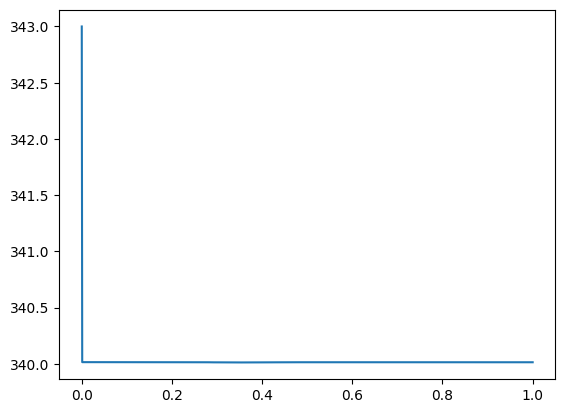

In [14]:
df = pd.DataFrame([x["Etotal"].sum(axis=1) for x,_ in res]).T
# df.loc[:].plot(alpha=0.1)
df.loc[:].mean(axis=1).plot()
# plt.gca().get_legend().remove()

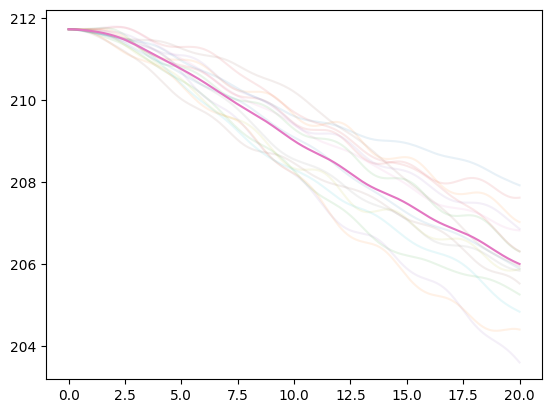

In [40]:
df = pd.DataFrame([(x["L"]).sum(axis=1) for x,_ in res]).T
df.loc[:].plot(alpha=0.1)
df.loc[:].mean(axis=1).plot()
plt.gca().get_legend().remove()
ax = plt.gca()

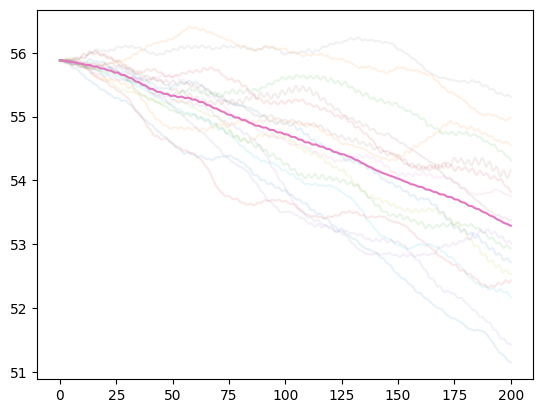

In [18]:
df = pd.DataFrame([(x["L"]).sum(axis=1) for x,_ in res]).T
df.loc[:].plot(alpha=0.1)
df.loc[:].mean(axis=1).plot()
plt.gca().get_legend().remove()
ax = plt.gca()

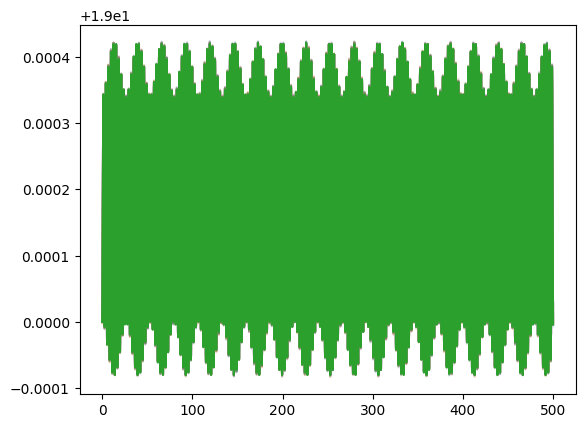

In [135]:
df = pd.DataFrame([x["Etotal"].sum(axis=1) for x,_ in res]).T
df.loc[:].plot(alpha=0.1)
df.loc[:].mean(axis=1).plot()
plt.gca().get_legend().remove()

In [136]:
dfs, hst = res[0]

In [137]:
hst.keys()

dict_keys(['time', 'rs', 'vs', 'KE', 'PE', 'IE', 'L', 'OMEGA', 'collisions', 'BInertia'])

In [146]:
zr = -hst["rs"] * hst["rs"][:,-1,None,:]
zr[:,-1,:] += (hst["rs"]**2).sum(axis=1)
Ltot = (hst["L"] + 0.5 * params_model["Bz"] * zr)

In [147]:
zr.shape

(5001, 3, 19)

In [148]:
Ltot.shape

(5001, 3, 19)

In [149]:
sim.abc

array([1., 1., 1.])

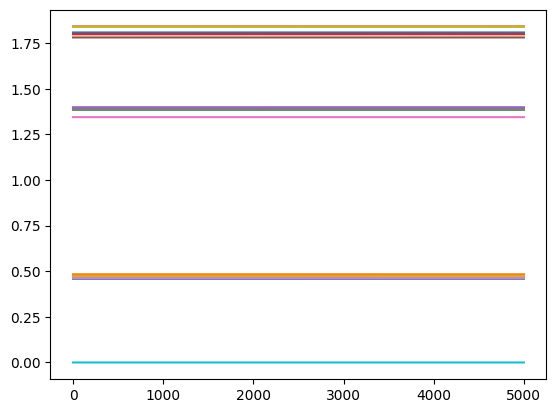

In [151]:
plt.plot(Ltot[:,2])

In [143]:
hst["L"]

array([[[ 8.9676648e-01,  3.0624755e-03,  2.1568532e-01, ...,
          2.4170989e-01,  1.4514927e-02,  9.1927510e-01],
        [-3.5848882e-02,  5.3043631e-03, -4.1286409e-01, ...,
         -3.9556211e-01,  2.5140591e-02, -3.5470884e-02],
        [ 1.2682194e+00,  9.8404211e-01,  3.2908285e-01, ...,
          3.2768869e-01,  9.8049957e-01,  1.3000513e+00]],

       [[ 8.9357543e-01,  3.0432791e-03,  1.7492479e-01, ...,
          2.0128636e-01,  1.4420583e-02,  9.1833556e-01],
        [-1.2501630e-01,  5.2726748e-03, -4.3478778e-01, ...,
         -4.1804066e-01,  2.4993416e-02, -1.2685429e-01],
        [ 1.2562889e+00,  9.7631669e-01,  3.2609889e-01, ...,
          3.2518238e-01,  9.7034502e-01,  1.2909222e+00]],

       [[ 8.8922548e-01,  2.9851659e-03,  1.3484009e-01, ...,
          1.6121975e-01,  1.4136036e-02,  9.1595674e-01],
        [-2.1191630e-01,  5.1799440e-03, -4.5545647e-01, ...,
         -4.3943214e-01,  2.4563681e-02, -2.1585555e-01],
        [ 1.2282362e+00,  9.5533705e

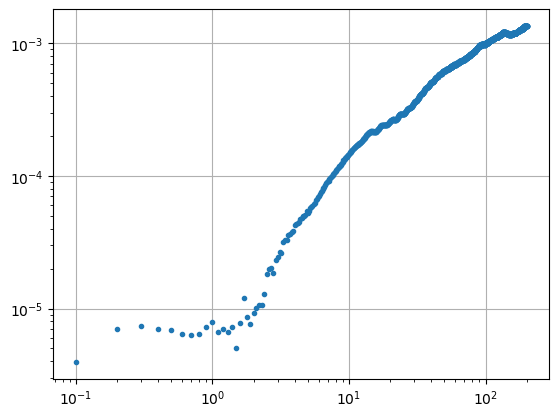

In [60]:
df.std(axis=1).plot(marker=".", lw=0)
plt.xscale("log");plt.yscale("log")
plt.grid()

Text(0.5, 1.0, 'slope = 0.8601')

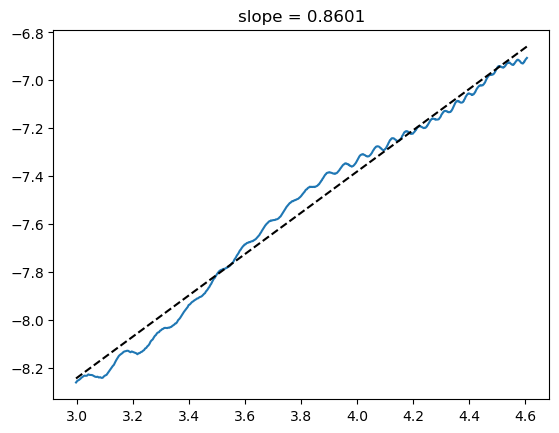

In [61]:
start = 20
end = 100 #len(df)
x = np.log(df.loc[start:end].index.values)
y = np.log(df.std(axis=1).loc[start:end].values)
plt.plot(x,y)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, x * slope + intercept, "--", c="k")
plt.title(f"slope = {slope:0.4f}")
